<a href="https://colab.research.google.com/github/fguidotti-git/transfer-learning/blob/main/DIO_TransferLearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os, zipfile
from pathlib import Path
import tensorflow as tf

URL = "https://download.microsoft.com/download/3/e/1/3e1c3f21-ecdb-4869-8368-6deba77b919f/kagglecatsanddogs_5340.zip"

# 1) Baixar SEM extrair automaticamente
zip_path = tf.keras.utils.get_file(origin=URL, fname="kagglecatsanddogs_5340.zip", extract=False)
print("ZIP baixado:", zip_path, "| existe?", os.path.isfile(zip_path))

# 2) Extrair manualmente para /content/datasets_ms
EXTRACT_ROOT = Path("/content/datasets_ms")
EXTRACT_ROOT.mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(EXTRACT_ROOT)
print("Extraído para:", EXTRACT_ROOT)

# 3) Localizar a pasta PetImages (deve conter Cat/ e Dog/)
pet_dir = None
for p in EXTRACT_ROOT.rglob("*"):
    if p.is_dir() and p.name == "PetImages":
        pet_dir = p
        break
print("PetImages:", pet_dir)

# 4) Conferir diretórios e contagens
def count_files(d: Path):
    if d is None or not d.is_dir():
        return 0
    return sum(1 for f in d.iterdir() if f.is_file())

cat_dir = pet_dir / "Cat" if pet_dir else None
dog_dir = pet_dir / "Dog" if pet_dir else None

print("Cat dir:", cat_dir, "exists:", bool(cat_dir and cat_dir.is_dir()))
print("Dog dir:", dog_dir, "exists:", bool(dog_dir and dog_dir.is_dir()))
print("n Cat files:", count_files(cat_dir))
print("n Dog files:", count_files(dog_dir))

# 5) Mostrar alguns nomes de arquivo só para amostrar
if cat_dir and cat_dir.is_dir():
    cat_samples = [p.name for p in list(cat_dir.iterdir())[:5]]
    print("Cat samples:", cat_samples)
if dog_dir and dog_dir.is_dir():
    dog_samples = [p.name for p in list(dog_dir.iterdir())[:5]]
    print("Dog samples:", dog_samples)


824887076/824887076 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
ZIP baixado: /root/.keras/datasets/kagglecatsanddogs_5340.zip | existe? True
Extraído para: /content/datasets_ms
PetImages: /content/datasets_ms/PetImages
Cat dir: /content/datasets_ms/PetImages/Cat exists: True
Dog dir: /content/datasets_ms/PetImages/Dog exists: True
n Cat files: 12501
n Dog files: 12501
Cat samples: ['7936.jpg', '12298.jpg', '7864.jpg', '4607.jpg', '2885.jpg']
Dog samples: ['7936.jpg', '12298.jpg', '7864.jpg', '4607.jpg', '2885.jpg']


In [4]:
# Passo 2 — Splits + tf.data (robusto, sem libs extras)

import random
from pathlib import Path
import tensorflow as tf

SEED = 123
random.seed(SEED)

BASE = Path("/content/datasets_ms/PetImages")
CAT_DIR = BASE / "Cat"
DOG_DIR = BASE / "Dog"

# 2.1) Listar apenas .jpg / .jpeg (reduz chance de erro de decodificação)
def list_jpegs(p: Path):
    return [str(x) for x in p.iterdir() if x.is_file() and x.suffix.lower() in (".jpg",".jpeg")]

cat_files = list_jpegs(CAT_DIR)
dog_files = list_jpegs(DOG_DIR)

print("Arquivos listados -> cats:", len(cat_files), "| dogs:", len(dog_files))

# 2.2) Embaralhar e split 80/10/10
def split_files(files, seed=SEED):
    files = files[:]  # cópia
    random.shuffle(files)
    n = len(files)
    n_train = int(0.8 * n)
    n_val   = int(0.1 * n)
    train = files[:n_train]
    val   = files[n_train:n_train+n_val]
    test  = files[n_train+n_val:]
    return train, val, test

cat_train, cat_val, cat_test = split_files(cat_files)
dog_train, dog_val, dog_test = split_files(dog_files)

train_paths = cat_train + dog_train
train_labels = [0]*len(cat_train) + [1]*len(dog_train)

val_paths = cat_val + dog_val
val_labels = [0]*len(cat_val) + [1]*len(dog_val)

test_paths = cat_test + dog_test
test_labels = [0]*len(cat_test) + [1]*len(dog_test)

print("Tamanhos -> train:", len(train_paths), "val:", len(val_paths), "test:", len(test_paths))

# 2.3) Criar tf.data que ignora arquivos problemáticos
IMG_SIZE = 224
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE

def decode_and_resize(path, label):
    # lê bytes + decodifica jpeg (3 canais), redimensiona e aplica preprocess da MobileNetV2
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=3)   # se o arquivo estiver corrompido, essa linha pode falhar
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    return img, label

def make_ds(paths, labels, training=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(4096, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTO)
    # ignora qualquer exemplo que falhar em decode_and_resize (ex.: imagem corrompida)
    ds = ds.apply(tf.data.experimental.ignore_errors())
    ds = ds.batch(BATCH_SIZE).prefetch(AUTO)
    return ds

train_ds = make_ds(train_paths, train_labels, training=True)
val_ds   = make_ds(val_paths,   val_labels,   training=False)
test_ds  = make_ds(test_paths,  test_labels,  training=False)

# 2.4) Verificar cardinalidade e um batch de exemplo
card_train = tf.data.experimental.cardinality(train_ds).numpy()
card_val   = tf.data.experimental.cardinality(val_ds).numpy()
card_test  = tf.data.experimental.cardinality(test_ds).numpy()
print("Batches -> train:", card_train, "val:", card_val, "test:", card_test)

x_batch, y_batch = next(iter(train_ds))
print("Batch shape:", x_batch.shape, y_batch.shape, "| y sample:", y_batch[:10].numpy())


Arquivos listados -> cats: 12500 | dogs: 12500
Tamanhos -> train: 20000 val: 2500 test: 2500


Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


Batches -> train: -2 val: -2 test: -2
Batch shape: (32, 224, 224, 3) (32,) | y sample: [0 0 0 0 0 0 0 0 0 0]


In [5]:
# Passo 3 — Modelo MobileNetV2 (feature extractor) + cabeça binária
import tensorflow as tf

IMG_SIZE = 224

base = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base.trainable = False  # fase 1: extrator de features congelado

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
import math, tensorflow as tf

# Usamos as variáveis já criadas no Passo 2:
# train_paths, val_paths, BATCH_SIZE, train_ds, val_ds

steps_per_epoch = (len(train_paths) + BATCH_SIZE - 1) // BATCH_SIZE
val_steps       = (len(val_paths)   + BATCH_SIZE - 1) // BATCH_SIZE

print("steps_per_epoch:", steps_per_epoch, "| val_steps:", val_steps)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
        restore_best_weights=True
    )
]

history1 = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=val_steps,
    epochs=3,   # CPU: começamos curto; depois podemos aumentar
    callbacks=callbacks,
    verbose=1
)


steps_per_epoch: 625 | val_steps: 79
Epoch 1/3
621/625 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9910 - loss: 0.0455

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


625/625 ━━━━━━━━━━━━━━━━━━━━ 897s 1s/step - accuracy: 0.9910 - loss: 0.0455 - val_accuracy: 0.9645 - val_loss: 0.1292
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 873s 1s/step - accuracy: 0.9921 - loss: 0.0205 - val_accuracy: 0.9810 - val_loss: 0.0637
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 878s 1s/step - accuracy: 0.9944 - loss: 0.0158 - val_accuracy: 0.9794 - val_loss: 0.0688


In [7]:
import tensorflow as tf

# Descongela um pedaço final da base (evita BatchNorm)
for layer in base.layers[-40:]:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

# LR menor para fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Evitar "ran out of data": repetir apenas o treino
train_ds_ft = train_ds.repeat()

history2 = model.fit(
    train_ds_ft,
    validation_data=val_ds,
    steps_per_epoch=steps_per_epoch,   # mesmas contas do passo anterior
    validation_steps=val_steps,
    epochs=2,                          # pode aumentar depois se quiser
    callbacks=callbacks,
    verbose=1
)


Epoch 1/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 1097s 2s/step - accuracy: 0.9947 - loss: 0.0149 - val_accuracy: 0.9770 - val_loss: 0.0743
Epoch 2/2
625/625 ━━━━━━━━━━━━━━━━━━━━ 1071s 2s/step - accuracy: 0.9962 - loss: 0.0098 - val_accuracy: 0.9887 - val_loss: 0.0352


In [8]:
import numpy as np
import tensorflow as tf

# Itera sobre test_ds coletando as labels reais e as probabilidades previstas
y_true_list, y_prob_list = [], []
for xb, yb in test_ds:
    y_true_list.append(yb.numpy())
    y_prob_list.append(model.predict(xb, verbose=0).ravel())

y_true = np.concatenate(y_true_list).astype(int)
y_prob = np.concatenate(y_prob_list)
y_pred = (y_prob >= 0.5).astype(int)

# Acurácia
acc = (y_pred == y_true).mean()

# Matriz de confusão (2x2) sem sklearn
cm = np.zeros((2, 2), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

# AUC com métrica do TF
auc_metric = tf.keras.metrics.AUC(curve="ROC")
auc_metric.update_state(y_true, y_prob)
auc_val = float(auc_metric.result().numpy())

print(f"Test Accuracy: {acc:.4f}")
print(f"Test ROC AUC:  {auc_val:.4f}")
print("Confusion Matrix (rows=true [cat,dog], cols=pred [cat,dog]):\n", cm)


Test Accuracy: 0.9895
Test ROC AUC:  0.9997
Confusion Matrix (rows=true [cat,dog], cols=pred [cat,dog]):
 [[1231    9]
 [  17 1221]]


In [9]:
import os

SAVE_DIR = "/content/export_simple"
os.makedirs(SAVE_DIR, exist_ok=True)

keras_path = os.path.join(SAVE_DIR, "cats_dogs_mobilenetv2.keras")
model.save(keras_path)  # formato nativo do Keras 3
print("Modelo salvo em:", keras_path)


Modelo salvo em: /content/export_simple/cats_dogs_mobilenetv2.keras


Test Accuracy: 0.9895
Test ROC AUC:  0.9997
Confusion Matrix (rows=true [cat,dog], cols=pred [cat,dog]):
 [[1231    9]
 [  17 1221]]


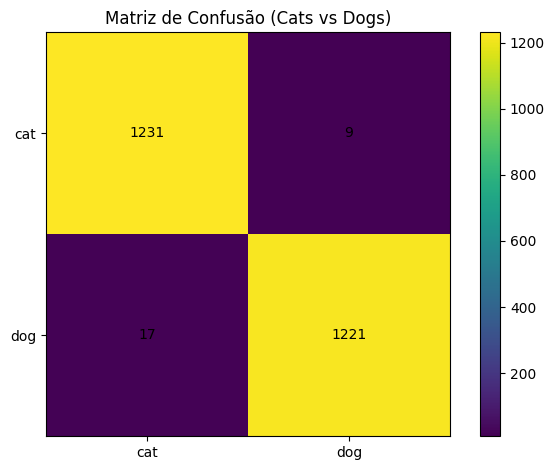

In [10]:
import numpy as np, matplotlib.pyplot as plt
import tensorflow as tf

# Recalcula métricas no test_ds
y_true, y_prob = [], []
for xb, yb in test_ds:
    y_true.append(yb.numpy())
    y_prob.append(model.predict(xb, verbose=0).ravel())
y_true = np.concatenate(y_true).astype(int)
y_prob = np.concatenate(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

acc = (y_pred == y_true).mean()

auc_metric = tf.keras.metrics.AUC(curve="ROC")
auc_metric.update_state(y_true, y_prob)
auc_val = float(auc_metric.result().numpy())

# Matriz de confusão 2x2 (cat=0, dog=1)
cm = np.zeros((2,2), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

print(f"Test Accuracy: {acc:.4f}")
print(f"Test ROC AUC:  {auc_val:.4f}")
print("Confusion Matrix (rows=true [cat,dog], cols=pred [cat,dog]):\n", cm)

# Figura da matriz
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de Confusão (Cats vs Dogs)")
plt.xticks([0,1], ["cat","dog"]); plt.yticks([0,1], ["cat","dog"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.colorbar(); plt.tight_layout(); plt.show()


In [11]:
import os, numpy as np, matplotlib.pyplot as plt, tensorflow as tf

SAVE_DIR = "/content/export_simple"
os.makedirs(SAVE_DIR, exist_ok=True)

# 1) Recalcular métricas e matriz de confusão
y_true, y_prob = [], []
for xb, yb in test_ds:
    y_true.append(yb.numpy())
    y_prob.append(model.predict(xb, verbose=0).ravel())
y_true = np.concatenate(y_true).astype(int)
y_prob = np.concatenate(y_prob)
y_pred = (y_prob >= 0.5).astype(int)

acc = (y_pred == y_true).mean()

auc_metric = tf.keras.metrics.AUC(curve="ROC")
auc_metric.update_state(y_true, y_prob)
auc_val = float(auc_metric.result().numpy())

cm = np.zeros((2,2), dtype=int)
for t, p in zip(y_true, y_pred):
    cm[t, p] += 1

# 2) Figura: matriz de confusão
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix (Cats vs Dogs)")
plt.xticks([0,1], ["cat","dog"]); plt.yticks([0,1], ["cat","dog"])
for (i,j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.colorbar(); plt.tight_layout()
cm_path = os.path.join(SAVE_DIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=140); plt.close()

# 3) Figura: amostras do teste com predição
#    (inverte preprocess_input: x in [-1,1] -> [0,255])
imgs_shown = 16
shown = 0
plt.figure(figsize=(10,10))
for xb, yb in test_ds.take(1):
    probs = model.predict(xb, verbose=0).ravel()
    for i in range(min(imgs_shown, xb.shape[0])):
        x = xb[i].numpy()
        x = np.clip((x + 1.0) * 127.5, 0, 255).astype(np.uint8)  # deprocess
        t = int(yb[i].numpy()); p = int(probs[i] >= 0.5)
        plt.subplot(4,4,i+1)
        plt.imshow(x)
        plt.axis("off")
        plt.title(f"pred:{'dog' if p else 'cat'}\nprob:{probs[i]:.2f} | true:{'dog' if t else 'cat'}", fontsize=8)
        shown += 1
        if shown >= imgs_shown:
            break
samples_path = os.path.join(SAVE_DIR, "test_samples_predictions.png")
plt.tight_layout(); plt.savefig(samples_path, dpi=140); plt.close()

# 4) Curvas (se history1/2 existem no ambiente)
try:
    def plot_and_save(histories, metric, outname):
        plt.figure()
        for i,h in enumerate(histories):
            if metric in h.history and f"val_{metric}" in h.history:
                plt.plot(h.history[metric], label=f"train {metric} (phase {i+1})")
                plt.plot(h.history[f"val_{metric}"], label=f"val {metric} (phase {i+1})")
        plt.xlabel("Epoch"); plt.ylabel(metric.title()); plt.legend(); plt.grid(True)
        path = os.path.join(SAVE_DIR, outname)
        plt.savefig(path, dpi=140); plt.close()
        return path

    acc_curve = plot_and_save([history1, history2], "accuracy", "curve_accuracy.png")
except NameError:
    acc_curve = None

print("Artefatos salvos em:", SAVE_DIR)
print("Accuracy:", round(acc,4), "| AUC:", round(auc_val,4))
print("Confusion matrix:\n", cm)


Artefatos salvos em: /content/export_simple
Accuracy: 0.9895 | AUC: 0.9997
Confusion matrix:
 [[1231    9]
 [  17 1221]]


In [13]:
import os

readme_lines = [
"# Transfer Learning — Cats vs Dogs (Kaggle/Microsoft)\n",
"\n- **Modelo:** MobileNetV2 (ImageNet) com cabeça densa sigmoide\n",
"- **Pipeline:** `tf.data` (decode_jpeg → resize 224 → preprocess_input), ignorando imagens inválidas\n",
"- **Treino:** Fase 1 (base congelada) + Fine-tuning (topo destravado)\n",
"\n## Resultados (teste)\n",
f"- Accuracy: **{acc:.4f}**\n",
f"- ROC AUC: **{auc_val:.4f}**\n",
"- Matriz de confusão (linhas=verdadeiro [cat,dog], colunas=previsto [cat,dog]):\n",
"```\n",
f"{cm}\n",
"```\n",
"\n## Artefatos\n",
"- `cats_dogs_mobilenetv2.keras`\n",
"- `confusion_matrix.png`\n",
"- `test_samples_predictions.png`\n",
]

readme = "".join(readme_lines)

SAVE_DIR = "/content/export_simple"
os.makedirs(SAVE_DIR, exist_ok=True)
path = os.path.join(SAVE_DIR, "README.md")
with open(path, "w", encoding="utf-8") as f:
    f.write(readme)

print("README.md criado em:", path)


README.md criado em: /content/export_simple/README.md


In [14]:
import shutil, os
zip_path = "/content/cats_dogs_export.zip"
if os.path.exists(zip_path):
    os.remove(zip_path)
shutil.make_archive("/content/cats_dogs_export", "zip", SAVE_DIR)

from google.colab import files
print("ZIP pronto em:", zip_path)
files.download(zip_path)


ZIP pronto em: /content/cats_dogs_export.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>